In [ ]:
import os
import abc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score
import tensorflow.keras.datasets.reuters as reuters
import tensorflow.keras.activations
import matplotlib.pyplot as plt

# Dane

In [ ]:
dict_size = 2000
(x_train, y_train), (x_test, y_test) = reuters.load_data(test_split=0.3,num_words=dict_size)
unique, frequency = np.unique(y_train,  
                              return_counts = True) 
x_train.shape

In [ ]:
classes = pd.DataFrame({'classes' : unique, 'frequency' : frequency}).nlargest(10,'frequency')
fig = plt.figure()
fig.suptitle('Rozkład 10 klas', fontsize=20)
plt.hist(x=classes.classes,weights=classes.frequency,bins=45,range=(1,45))
plt.show()

In [ ]:
train_set = pd.DataFrame({'x':x_train,'y':y_train})
test_set = pd.DataFrame({'x':x_test,'y':y_test})
train_set

In [ ]:
train_set.y.isin(classes['classes'])

In [ ]:
filtered_train_set = train_set[train_set.y.isin(classes['classes'])]
filtered_train_set['y']=filtered_train_set['y'].astype('category').cat.codes

filtered_test_set  = test_set[test_set.y.isin(classes['classes'])]
filtered_test_set['y']=filtered_test_set['y'].astype('category').cat.codes

In [ ]:
def plot_hist(dataset,title):
    fig = plt.figure()
    fig.suptitle('Rozkład klas ' + title, fontsize=20)
    plt.hist(x=dataset.y)
    plt.show()

In [ ]:
plot_hist(train_set,"zbiór treningowy przed filtorwanie")
plot_hist(filtered_train_set,"zbiór treningowy po filtrowaniu")
plot_hist(test_set,"zbiór testowy przed filtorwanie")
plot_hist(filtered_test_set,"zbiór testowy po filtrowaniu")


# Model rekurecyjny

In [ ]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass
    
class Custom_Embedding_layer(AbstractLayer):
    
    def __init__(self,embedding_size,Dim):
        """Inits the class."""
        super(Custom_Embedding_layer, self).__init__()
        self.embedding_table = self.add_weight(shape=(Dim,embedding_size),
                                      initializer=tf.random_normal_initializer,
                                      trainable=True)
        
    def call(self, inputs):
        """Makes forward pass of the layer."""
        #inputs should be after padding
        word_embeddings = tf.nn.embedding_lookup(self.embedding_table,inputs)
        return word_embeddings
    
class Custom_RNN(AbstractLayer):
    
    def __init__(self, hidden_state_size, output_size,): 
        super(Custom_RNN, self).__init__()
        self.tahn = tensorflow.keras.activations.tanh
        self.softmax = tensorflow.keras.activations.softmax
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        
    def build(self, input_shape):
        self.Whx = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Whh = self.add_weight(shape=(self.hidden_state_size, self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Why = self.add_weight(shape=(self.output_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.bh = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.by = self.add_weight(shape=(self.output_size,1),initializer=tf.random_uniform_initializer,trainable=True)
           
        
    def step_function(self,inputs,state):
        
        inputs=tf.reshape(inputs,shape=(-1,inputs.shape[1],1))
        state=tf.reshape(state,shape=(-1,self.hidden_state_size,1))
        # h(t) = tahn (Whx*x(t) + Whh*h(t-1)+bh)
        h = self.tahn(tf.matmul(self.Whx,inputs) + tf.matmul(self.Whh,state) + self.bh)
        #print('h',h.shape,self.by.shape)
        sum = tf.matmul(self.Why,h) + self.by
        # y(t) = softmax (Wyh * h(t)  +by)
        output = self.softmax(sum,axis=0)
        return output, h
    
    
    def call(self, inputs):
        """Makes forward pass of the layer."""
        initial_states = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        last, outputs, states = tf.keras.backend.rnn(self.step_function, inputs, [initial_states])
        last = tf.reshape(last,(-1,self.output_size))
        return last
     

In [ ]:
class Custom_LSTM(AbstractLayer):
    
    def __init__(self, hidden_state_size, output_size): 
        super(Custom_LSTM, self).__init__()
        self.tahn = tensorflow.keras.activations.tanh
        self.softmax = tensorflow.keras.activations.softmax
        self.sigmoid = tensorflow.keras.activations.sigmoid
        
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        
        self.point_wise_multi = tf.math.multiply
        self.point_wise_add = tf.math.add
        
    def build(self, input_shape):
        self.concat_size = self.hidden_state_size+input_shape[2]
        i = input_shape[-1]
        self.Whf = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Whu = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Whc = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Who = self.add_weight(shape=(self.hidden_state_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.Wfx = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxu = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxc = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        self.Wxo = self.add_weight(shape=(self.hidden_state_size,input_shape[-1]),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True)
        
        self.bf = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bi = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bc = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
        self.bo = self.add_weight(shape=(self.hidden_state_size,1),initializer=tf.random_uniform_initializer,trainable=True)
    
        self.Why = self.add_weight(shape=(self.output_size,self.hidden_state_size),
                                      initializer=tf.random_uniform_initializer,
                                      trainable=True,name="lstm cell h state weight not used in bilst")
        self.by = self.add_weight(shape=(self.output_size,1),initializer=tf.random_uniform_initializer,trainable=True,
                                 name="lstm cell h state bias not used in bilst")
        pass
           
        
    def step_function(self,inputs,state):
        inputs=tf.reshape(inputs,shape=(-1,inputs.shape[1],1))
        H_state=tf.reshape(state[0],shape=(-1,self.hidden_state_size,1))
        C_state=tf.reshape(state[1],shape=(-1,self.hidden_state_size,1))

        matmul1 = tf.matmul(self.Whf,H_state)
        matmul2 = tf.matmul(self.Wfx,inputs)
        ft=self.sigmoid(tf.matmul(self.Whf,H_state)+tf.matmul(self.Wfx,inputs)+self.bf)
        ut=self.sigmoid(tf.matmul(self.Whu,H_state)+tf.matmul(self.Wxu,inputs)+self.bi)
        cti=self.tahn(tf.matmul(self.Whc,H_state)+tf.matmul(self.Wxc,inputs)+self.bc)
        
        ct=self.point_wise_multi(cti,ut)+self.point_wise_multi(C_state,ft)
        
        ot = self.sigmoid(tf.matmul(self.Who,H_state)+tf.matmul(self.Wxo,inputs)+self.bo)
        new_H_state=self.point_wise_multi(ot,self.tahn(ct))
        new_C_state=ct
        
        output =tf.matmul(self.Why,new_H_state)+self.by
        output = self.softmax(output,axis=1)
        
        
        new_states = [new_H_state,new_C_state]
        return output, new_states
   
    
    
    def call(self, inputs):
        """Makes forward pass of the layer."""
        initial_state_h = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_state_c = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_states = [initial_state_h,initial_state_c]
        last, outputs, states = tf.keras.backend.rnn(self.step_function, inputs, initial_states)
        #print(last)
        last = tf.reshape(last,(-1,self.output_size))
        #print('after',last)
        return last

In [ ]:
class LSTM_cell(Custom_LSTM):
    """Abstract Layer."""

    def __init__(self, hidden_state_size, output_size,reverse_direction=False):
        """Inits the class."""
        super(LSTM_cell, self).__init__(hidden_state_size, output_size)
        self.reverse_direction = reverse_direction
        

    def step_function(self,inputs,state):
        inputs=tf.reshape(inputs,shape=(-1,inputs.shape[1],1))
        H_state=tf.reshape(state[0],shape=(-1,self.hidden_state_size,1))
        C_state=tf.reshape(state[1],shape=(-1,self.hidden_state_size,1))

        matmul1 = tf.matmul(self.Whf,H_state)
        matmul2 = tf.matmul(self.Wfx,inputs)
        ft=self.sigmoid(tf.matmul(self.Whf,H_state)+tf.matmul(self.Wfx,inputs)+self.bf)
        ut=self.sigmoid(tf.matmul(self.Whu,H_state)+tf.matmul(self.Wxu,inputs)+self.bi)
        cti=self.tahn(tf.matmul(self.Whc,H_state)+tf.matmul(self.Wxc,inputs)+self.bc)

        ct=self.point_wise_multi(cti,ut)+self.point_wise_multi(C_state,ft)

        ot = self.sigmoid(tf.matmul(self.Who,H_state)+tf.matmul(self.Wxo,inputs)+self.bo)
        new_H_state=self.point_wise_multi(ot,self.tahn(ct))
        new_C_state=ct      

        new_states = [new_H_state,new_C_state]
        
        return new_C_state, new_states 
    
    def call(self, inputs):
        """Makes forward pass of the layer."""
        initial_state_h = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_state_c = tf.zeros(shape=[inputs.shape[0],self.hidden_state_size,1])
        initial_states = [initial_state_h,initial_state_c]
        last, outputs, states = tf.keras.backend.rnn(self.step_function, inputs, initial_states,go_backwards=self.reverse_direction)
        return last    

In [ ]:
class Custom_bidirectional_LSTM_block(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self, hidden_state_size, output_size):
        """Inits the class."""
        super(Custom_bidirectional_LSTM_block, self).__init__()

        self.tahn = tensorflow.keras.activations.tanh
        self.softmax = tensorflow.keras.activations.softmax
        self.sigmoid = tensorflow.keras.activations.sigmoid
        
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        
        self.forward_lstm = LSTM_cell(self.hidden_state_size, self.output_size, reverse_direction=False)
        self.backward_lstm = LSTM_cell(self.hidden_state_size, self.output_size, reverse_direction=True)
        
        
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        h_forward = self.forward_lstm(inputs)
        h_backward = self.backward_lstm(inputs)
        x = tf.concat([h_forward,h_backward],axis=1)
        return x

In [ ]:
class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass
    
class Custom_model_RNN(AbstractModel):
    """Abstract model."""

    def __init__(self,embedding_size,embedding_dim,output_size,hidden_state,rnn_type='rnn'):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.embedding = Custom_Embedding_layer(embedding_size,embedding_dim)
       # self.embedding = tf.keras.layers.Embedding(embedding_size, embedding_dim)
        if rnn_type is 'rnn':
          self.rnn = Custom_RNN(hidden_state_size=hidden_state,output_size=output_size)
        elif rnn_type is 'lstm':
          self.rnn = Custom_LSTM(hidden_state_size=hidden_state,output_size=output_size)
        self.output_size=output_size
            
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x=self.embedding(inputs)
        x=self.rnn(x)
        return x

    def predict(self, x):
        """Predicts x"""
        #print("predict")
        pred=self.call(x,trening=False)
        pred = tf.argmax(input=pred,axis=1)
        return pred

In [ ]:
class Custom_model_Bilstm(AbstractModel):
    """Abstract model."""

    def __init__(self,embedding_size,embedding_dim,output_size,hidden_state,embeding=True):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.embeding = embeding
        if embeding:
            self.embedding = Custom_Embedding_layer(embedding_size,embedding_dim)
        self.bilstm_block = Custom_bidirectional_LSTM_block(hidden_state_size=hidden_state,output_size=output_size)
        self.hidden_state = hidden_state
        self.output_size=output_size
        self.dense = tf.keras.layers.Dense(self.output_size, activation='softmax')
            
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        if self.embeding:
            x=self.embedding(inputs)
        else:
            x=inputs
        #print(x.shape)
        x=self.bilstm_block(x)
        #print('bilstm',x.shape)
        x=tf.reshape(x,(-1,2*self.hidden_state))
        #print('bilstm reshape',x.shape)
        x=self.dense(x)
       # print('dense',x.shape)
       
        return x

    def predict(self, x):
        """Predicts x"""
        #print("predict")
        pred= self.call(x,trening=False)
        pred = tf.argmax(input=pred,axis=1)
        return pred

In [ ]:
def f1(y_true,y_pred):
    #print('true shape: ',y_true.shape)
    #print('predict shape:',y_pred.shape)
    re= tf.argmax(y_pred,axis=1)
    re = tf.reshape(re,[-1,1])
    
    #print(re.shape, y_true.shape)
    F1 = f1_score(y_true=y_true.numpy(),y_pred=re,average="macro")
    #print(F1)
    return F1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
log_dir_path = F"/content/drive/"+"My Drive"+"/logs/"

#### Padding i embedingi

In [ ]:
data = reuters.get_word_index()
reverse = inv_map = {v: k for k, v in data.items()}
word_x_train = []
for i, arr in enumerate(filtered_train_set['x']):
    word_x_train.append([])
    for k,word in enumerate(arr):
        word_x_train[i].append(reverse[word])
word_x_test = []        
for i, arr in enumerate(filtered_test_set['x']):
    word_x_test.append([])
    for k,word in enumerate(arr):
        word_x_test[i].append(reverse[word])
        

In [ ]:
maxlen = 60
x_train = filtered_train_set['x']
x_test = filtered_test_set['x']
print(x_train[1],x_train.shape)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,maxlen=maxlen)
x_train.shape
print(x_train[1],x_train.shape)
x_train

# Badania - RNN

In [ ]:
model=Custom_model_RNN(embedding_size=128,embedding_dim=dict_size,output_size=10,hidden_state=16,rnn_type='rnn')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [ ]:
log_dir = log_dir_path+"rnn"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,validation_data=(x_test,filtered_test_set['y']),
          callbacks=[tensorboard_callback]
         )

# Badania - LSTM


In [ ]:
model=Custom_model_RNN(embedding_size=128,embedding_dim=dict_size,output_size=10,hidden_state=16,rnn_type='lstm')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [ ]:
log_dir = log_dir_path+"lstm"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,
          callbacks=[tensorboard_callback],validation_data=(x_test,filtered_test_set['y']))

# Embedingi

In [ ]:
!pip install pymagnitude

In [ ]:
from pymagnitude import Magnitude, MagnitudeUtils

In [ ]:

path_to_vectors = ["wiki-news-300d-1M-subword.magnitude"]
if not os.path.isfile(path_to_vectors[0]):
    vecs = Magnitude(MagnitudeUtils.download_model("fasttext/light/wiki-news-300d-1M-subword.magnitude"))
else:
    vecs = Magnitude(path_to_vectors[0])

In [ ]:
train = vecs.query(word_x_train,pad_to_length=maxlen)
test = vecs.query(word_x_test,pad_to_length=maxlen)
test = tf.convert_to_tensor(test)

# Badania - BiLstm

In [ ]:
model=Custom_model_Bilstm(embedding_size=300,embedding_dim=dict_size,output_size=10,hidden_state=16)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [ ]:
#log_dir = log_dir_path+"bilstm-custom_embeding"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
tf.get_logger().setLevel('ERROR') #un used weights make lot of warnings
model.fit(x=x_train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,validation_data=(test,filtered_test_set['y'],
          callbacks=[tensorboard_callback]
         )

# Badania - Bilstm z pre trenowanymi embedingami

In [ ]:
model=Custom_model_Bilstm(embedding_size=300,embedding_dim=dict_size,output_size=10,hidden_state=16,embeding=False)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=[f1],
    run_eagerly=True #for tensor.numpy() in f1 score metric
)

In [ ]:
log_dir = log_dir_path+"bilstm-custom_embeding"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
tf.get_logger().setLevel('ERROR') #un used weights make lot of warnings
model.fit(x=train,y=filtered_train_set['y'],
          epochs=25, batch_size=200,validation_data=(test,filtered_test_set['y']),
          callbacks=[tensorboard_callback]
         )

In [ ]:
names_of_embeding = ["wiki-news-300d-1M-subword.magnitude","GoogleNews-vectors-negative300.magnitude","glove.twitter.27B.200d.magnitude"]
download_paths = ["fasttext/light/wiki-news-300d-1M-subword.magnitude","word2vec/light/GoogleNews-vectors-negative300.magnitude","/glove/light/glove.twitter.27B.200d.magnitude"]


In [ ]:
names_of_embeding = ["GoogleNews-vectors-negative300.magnitude"]
download_paths = ["word2vec/light/GoogleNews-vectors-negative300.magnitude"]

from pymagnitude import Magnitude, MagnitudeUtils
log_dir_path = 'logs/'
for i, name in enumerate(names_of_embeding):
    if not os.path.isfile(name):
        vecs = Magnitude(MagnitudeUtils.download_model(download_paths[i]))
    else:
        vecs = vecs = Magnitude(name)
    #data embedding
    train = vecs.query(word_x_train,pad_to_length=maxlen)
    test  = vecs.query(word_x_test,pad_to_length=maxlen)
    #model
    model=Custom_model_Bilstm(embedding_size=None,embedding_dim=None,output_size=10,hidden_state=16,embeding=False)
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(lr=0.001),
        metrics=[f1],
        run_eagerly=True #for tensor.numpy() in f1 score metric
    )
    log_dir = log_dir_path+name+'2'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
    tf.get_logger().setLevel('ERROR') #un used weights make lot of warnings
    model.fit(x=train,y=filtered_train_set['y'],
              epochs=25, batch_size=200,
              callbacks=[tensorboard_callback],
              validation_data=(test,filtered_test_set['y'])
             )

# Wnioski

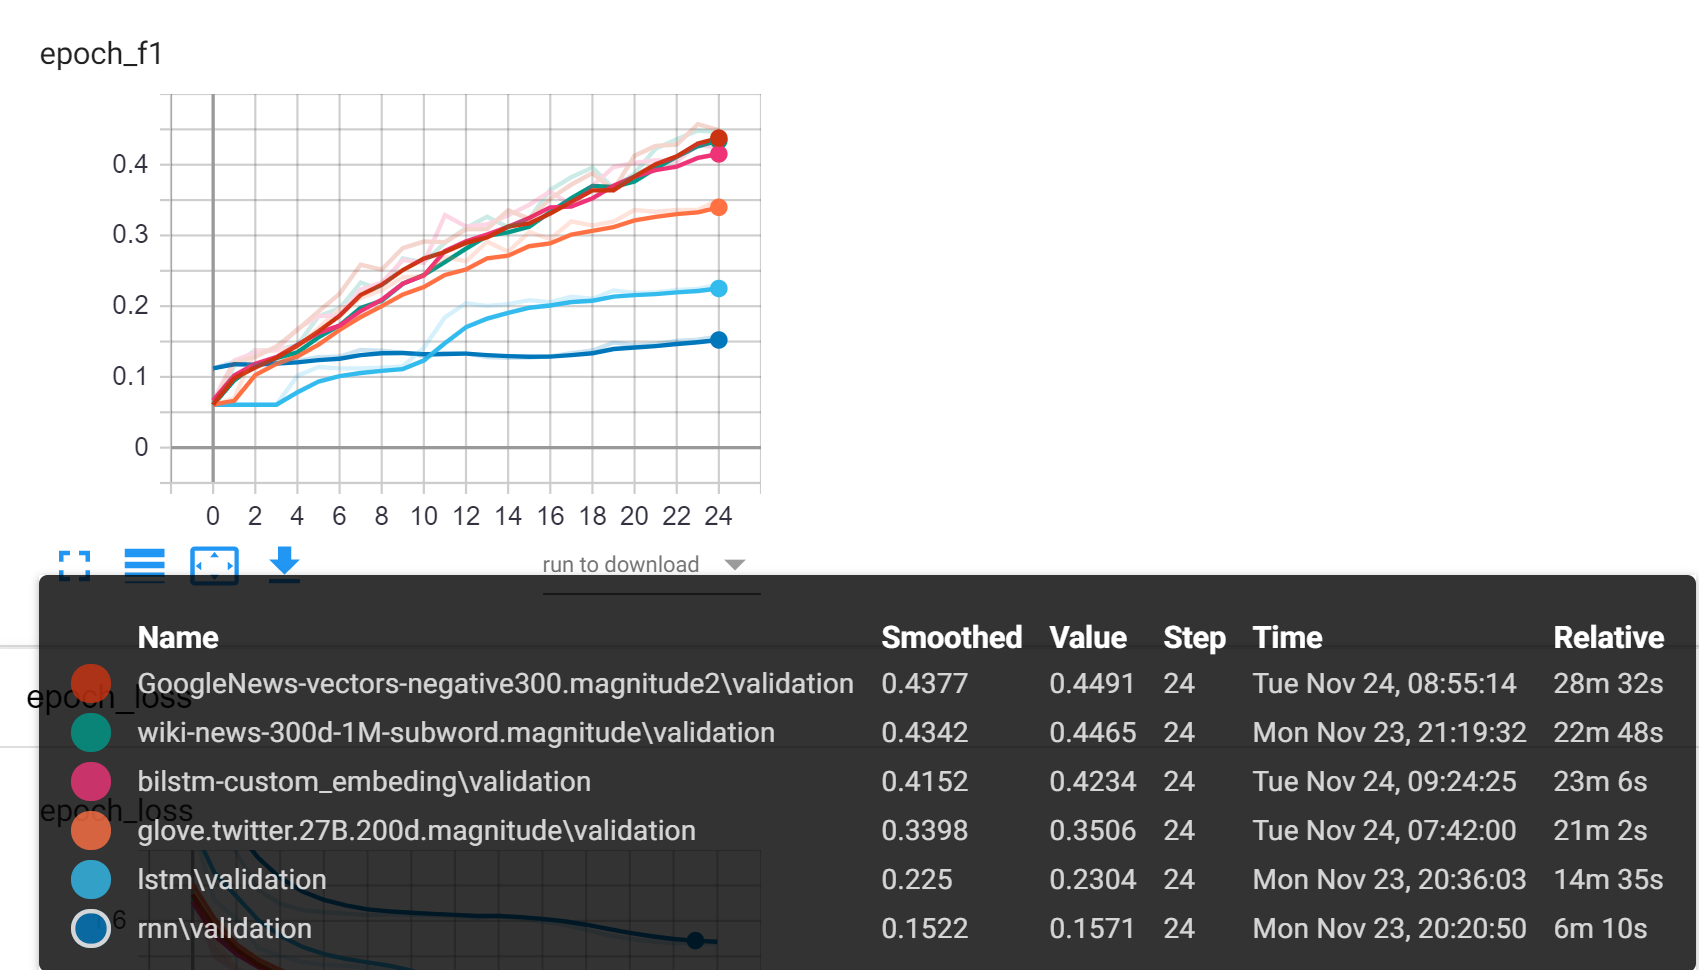

1. Niektóre pre-trenowane embeddingi okazały sie za wielkie aby w przeciągu jednej nocy przetłumaczyć zały zbiór uczący. Mowa o ELOMo  http://magnitude.plasticity.ai/elmo/light/elmo_2x1024_128_2048cnn_1xhighway_weights.magnitude
2. Wyćwiczenie własnej warstwy embeddingowej trwa, dlatego opłaca się używać gotowych pre-trenowanych embeddingów. Oczywiście trzeba dobierać je językowo 
3. Można zauwazyć że pomimo że embedding glove był pre-trenowanym embbedingiem to poradził sobie gorzej o 8 punktów procentowych w fscore, może to być spowodowowane wielkością embedding, gdyż ten embedding posiadał wektory o długości 200, a każdy customowy embedding 300.
4. GoogleNews i WikiNeews dały praktycznie porównywalne wyniki. W porównaniu z innymi emebbedingmami. Można by spróbować wziąć embedding o jeszcze większym wektorze, aby zobaczyć czy zdecydowanie się poprawi wynik.
5. Ilość słów w zbiorze też miała duże znaczenie. Początkowo dla samych testów brałem tylko 20 najczęściej występujących słów, przez co pojedyńczy artykuł potrafił wyglądać mniej więcej tak [1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,10]
6. Użycie dwukierunkowości nie wydłużyło znacznie czasu wynonywania treningu. Jedynie o jakieś 8 minut.
7. Wagi nieużywane w tensorflow będą powodować irytujące warningi
8. Uzycie dwukierunkowości zwiększyło fscore (na tych samych parametrach badawczych i tym samym seedzie) o prawie 100%.

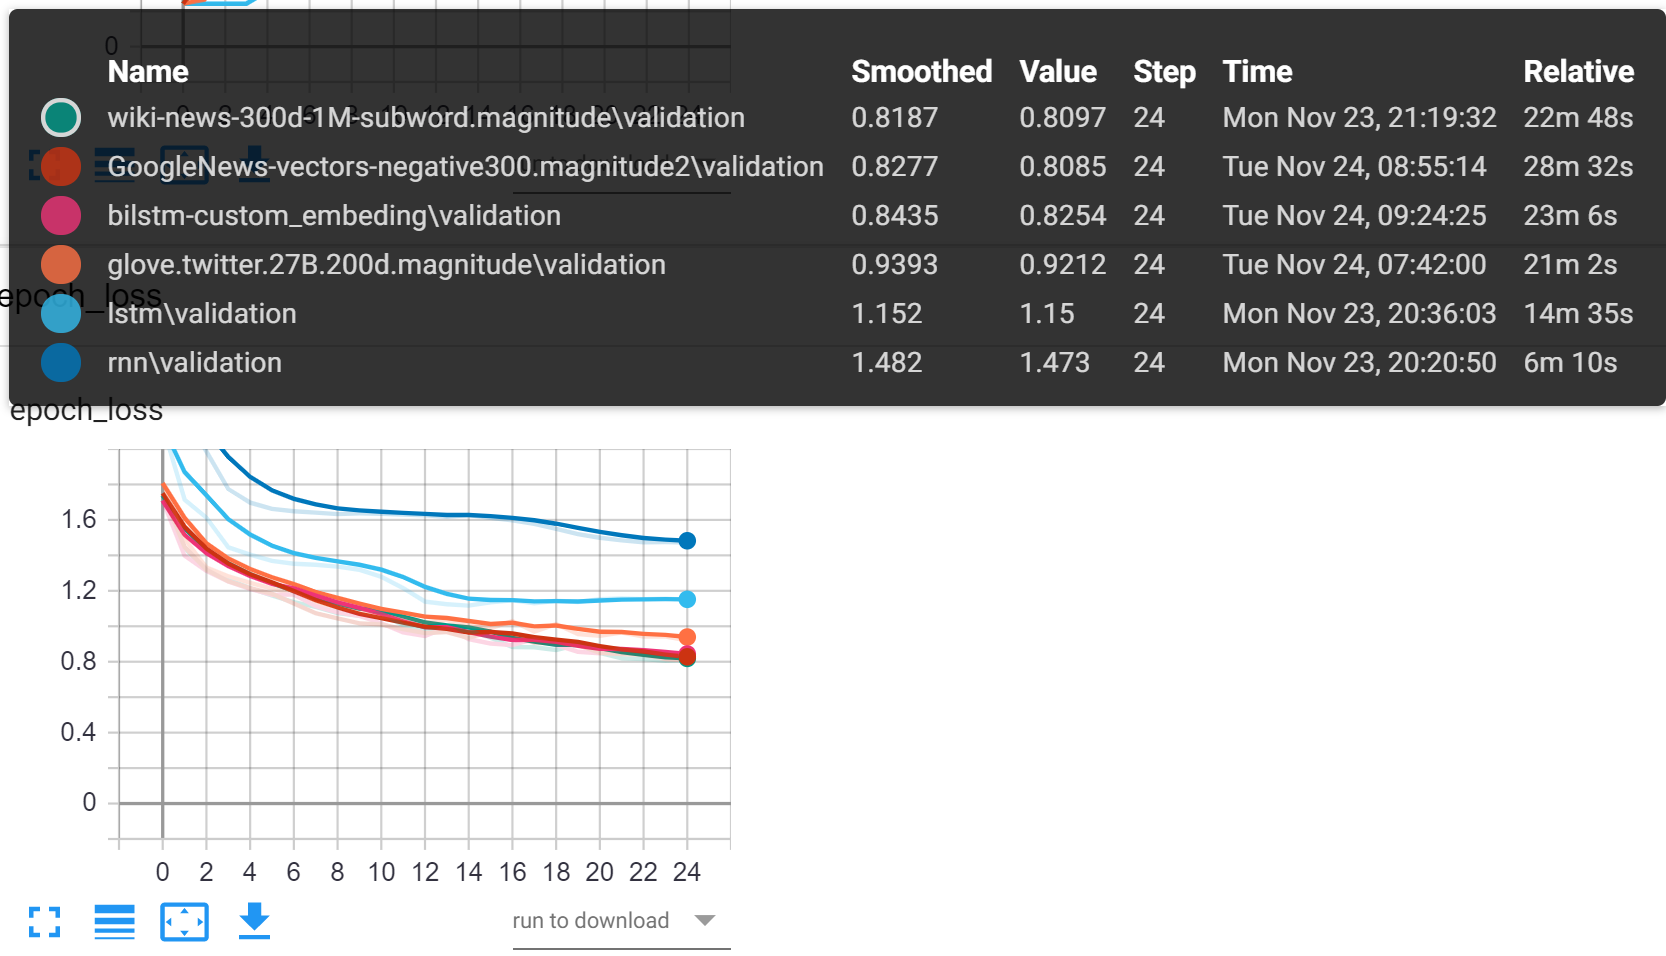